<a href="https://colab.research.google.com/github/victoraccete/ML_Notebooks/blob/master/Pneumonia_detection_with_CNNs_with_and_without_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Binary classification of pneumonia using CNN with Tensorflow
#### Notebook created by Victor Accete ([Linkedin](https://www.linkedin.com/in/victor-accete/)).
 



### Introduction
This notebooks has educational purposes. Here I built a binary classifier, to classify if a chest x-ray image displays lungs with pneumonia or not. In addition to this, I explore some concepts and techniques to demonstrate how to deal with an overfitting issue encountered. 

For this, I'm using Tensorflow with Keras, in addition to some plotting using matplotlib and plotly to aid our explorations and thought process.

Hopefully this notebook can also become educational for someone else, so here I try my best to make it clear and easy to understand and reproduce.

The dataset used here was not created by me and can be found on Kaggle [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). 

### Concepts explored in this notebook:
- Convolutional Neural Networks
- Data Augmentation
- Importance of test and validation sets
- Binary Classification

### Let's get started: downloading and accessing the data

In order to download a dataset from Kaggle, you need to upload your Kaggle API Token. If the Colab runtime closes and you have to download the dataset from Kaggle again, you'll need to reupload your API Token. 

If you want to know how to get your token, please check [here](https://github.com/Kaggle/kaggle-api#:~:text=API%20credentials,file%20containing%20your%20API%20credentials.). 

In case you have trouble with this step, you can download the dataset manually (from [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) and you can upload the zip file to Colab's 'Content' folder. Then you can skip the next steps and go straight to the zip extraction cell. 


In [1]:
# importing kaggle.json to use the api 
from google.colab import files
files.upload()
; # suppressing output to hide API informations

Saving kaggle.json to kaggle (1).json


'# suppressing output to hide API informations'

In [2]:
# we'll need this to download the dataset
!pip install kaggle

In [3]:
# since Kaggle's kaggle.json expects to be in 
# ~/.kaggle/kaggle.json, we're creating it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
;

''

So now we have everything ready to download the dataset. Good, let's do this! Note that it may take a while to download.

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# it is expected for it to be downloaded to /content folder. 

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


Ok. So the file is now downloaded to 'content' folder. You can check it in your colab sidebar. 

As you can see the file is a zipped file: 'chest-xray-pneumonia.zip'. Next step is extracting these files. We'll do this in the following code cell.

We're extracting the files to the '/tmp' folder, which you can check in your google colab sidebar as well. 

In [5]:
# zip extraction cell
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('../tmp')
zip_ref.close()

### Inspecting the data

This is a important step, because inspecting data can give us insights about how our data looks like. So we can possibly evaluate its quality and try to spot its weakenesses. For example, by inspecting data I can maybe notice that it lacks diversity, or that all images are in grayscale, etc. 

Note that this step isn't exclusive to image datasets, but to all kinds of data. 

First, I assign folders' names to variables, to make it easier to reuse them later on. 

In [6]:
train_normal_dir = '/tmp/chest_xray/train/NORMAL/'
train_pneumonia_dir = '/tmp/chest_xray/train/PNEUMONIA/'
test_normal_dir = '/tmp/chest_xray/test/NORMAL/'
test_pneumonia_dir = '/tmp/chest_xray/test/PNEUMONIA/'
val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
val_pneumonia_dir = '/tmp/chest_xray/val/PNEUMONIA/'
train_dir = '/tmp/chest_xray/train/'
test_dir = '/tmp/chest_xray/test/'
val_dir = '/tmp/chest_xray/val/'

Let's print how many files we have in each folder. Just to check it. 

In [7]:
# checking folders lengths to see how many files we have in each folder. 
import os
print("Train set (normal): " + str(len(os.listdir(train_normal_dir))))
print("Train set (pneumonia): " + str(len(os.listdir(train_pneumonia_dir))))
print("Test set (normal): " + str(len(os.listdir(test_normal_dir))))
print("Test set (pneumonia): " + str(len(os.listdir(test_pneumonia_dir))))
print("Validation set (normal): " + str(len(os.listdir(val_normal_dir))))
print("Validation set (pneumonia): " + str(len(os.listdir(val_pneumonia_dir))))


Train set (normal): 1347
Train set (pneumonia): 3879
Test set (normal): 234
Test set (pneumonia): 390
Validation set (normal): 140
Validation set (pneumonia): 392


So we don't have that much data, and specifically concerning the validation set, it can be problematic. Later on I try to artificially expand our data using data augmentation just to experiment if the results are better with it or not.

However, I still have to deal with this validation set issue before fitting our model. I need to do this because if it remains as it is (16 images for validation set) we won't get meaningful informations about how well our model does with unseen data, so we won't be able to properly improve our model. 

To achieve this end, I just move the 16 images from the validation folders to the training folders. Afterwards, from the training set, I'll split a portion to use as a decently sized validation set. 

In [8]:
from shutil import copyfile
# -------------------------------------------------------------------------- #
# This function receives a list of files name, a source path and a --------- #
# a destination path. It then iterates over the files list, appending the -- #
# files names to the end of the path provided and copies it to the provided  #
# destination folder. ------------------------------------------------------ #
# -------------------------------------------------------------------------- #
def cutfiles(files_list, source_folder, destination_folder):
  # the files_list has only the file names
  for file_name in files_list:
    # appends the full path + filename 
    src = str(source_folder) + str(file_name)
    dst = str(destination_folder) + str(file_name)
    copyfile(src, dst)
    os.remove(src)
  print("Moved files correctly.")
  return None

In [9]:
'''
Just to refresh our memory, our validation data are in these folders:
val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
val_pneumonia_dir = '/tmp/chest_xray/val/PNEUMONIA/'
'''
# getting the files list from these folders
normal_files_list = os.listdir(val_normal_dir)
pneumonia_files_list = os.listdir(val_pneumonia_dir)
print(normal_files_list)
print(pneumonia_files_list)

# copying files from validation folder to training folder
cutfiles(normal_files_list, val_normal_dir, train_normal_dir)
cutfiles(pneumonia_files_list, val_pneumonia_dir, train_pneumonia_dir)

['NORMAL2-IM-0629-0001.jpeg', 'IM-0183-0001.jpeg', 'IM-0525-0001-0002.jpeg', 'IM-0687-0001.jpeg', 'IM-0761-0001.jpeg', 'IM-0698-0001.jpeg', 'IM-0326-0001.jpeg', 'NORMAL2-IM-1333-0001.jpeg', 'NORMAL2-IM-1154-0001-0001.jpeg', 'IM-0625-0001.jpeg', 'NORMAL2-IM-0599-0001.jpeg', 'NORMAL2-IM-1160-0001.jpeg', 'NORMAL2-IM-1261-0001.jpeg', 'NORMAL2-IM-0476-0001.jpeg', 'NORMAL2-IM-0395-0001-0001.jpeg', 'NORMAL2-IM-0821-0001.jpeg', 'IM-0323-0001.jpeg', 'NORMAL2-IM-0942-0001.jpeg', 'NORMAL2-IM-1041-0001.jpeg', 'NORMAL2-IM-0736-0001.jpeg', 'NORMAL2-IM-0974-0001.jpeg', 'NORMAL2-IM-1241-0001.jpeg', 'IM-0652-0001.jpeg', 'IM-0757-0001.jpeg', 'IM-0501-0001-0001.jpeg', 'NORMAL2-IM-1214-0001.jpeg', 'NORMAL2-IM-1306-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-0875-0001.jpeg', 'NORMAL2-IM-0930-0001.jpeg', 'NORMAL2-IM-1156-0001.jpeg', 'NORMAL2-IM-1440-0001.jpeg', 'NORMAL2-IM-1188-0001.jpeg', 'NORMAL2-IM-0667-0001.jpeg', 'IM-0652-0001-0002.jpeg', 'NORMAL2-IM-0440-0001.jpeg', 'NORMAL2-IM-1222-0001.jpeg

Previously, we had 1341 in the normal images training folder and 3875 in the pneumonia training folder. 

Now, we have:

In [10]:
print("Train set (normal): " + str(len(os.listdir(train_normal_dir))))
print("Train set (pneumonia): " + str(len(os.listdir(train_pneumonia_dir))))
print("Validation set (normal): " + str(len(os.listdir(val_normal_dir))))
print("Validation set (pneumonia): " + str(len(os.listdir(val_pneumonia_dir))))

Train set (normal): 1349
Train set (pneumonia): 3883
Validation set (normal): 0
Validation set (pneumonia): 0


So we can see that it correctly copied the 16 files from validation folder to our training folder, then deleted. Now I'll put some files in our validation folder again, but this time I'm putting a reasonable amount.  

In [11]:
import random
# only 10%. Change this if you want to experiment with different proportions
val_percentage = 0.1 # change this if you want a different size for validation set
# the following line is needed because random.sample second parameter expects
# an integer. So the next line computes this number by multiplying how many files
# I have times how much % I want
val_size = int(len(os.listdir(train_normal_dir))*val_percentage)
shuffled_normal_val_files = random.sample(os.listdir(train_normal_dir), val_size)
val_size = int(len(os.listdir(train_pneumonia_dir))*val_percentage)
shuffled_pneumonia_val_files = random.sample(os.listdir(train_pneumonia_dir), val_size)

cutfiles(shuffled_normal_val_files, train_normal_dir, val_normal_dir)
cutfiles(shuffled_pneumonia_val_files, train_pneumonia_dir, val_pneumonia_dir)
print("Train set (normal): " + str(len(os.listdir(train_normal_dir))))
print("Train set (pneumonia): " + str(len(os.listdir(train_pneumonia_dir))))
print("Validation set (normal): " + str(len(os.listdir(val_normal_dir))))
print("Validation set (pneumonia): " + str(len(os.listdir(val_pneumonia_dir))))

Moved files correctly.
Moved files correctly.
Train set (normal): 1215
Train set (pneumonia): 3495
Validation set (normal): 134
Validation set (pneumonia): 388


So now we finally have a decently-sized validation set. We can go on from now. Please note that these steps are not exactly necessary for the code to run, but it is a good practice to have a significant validation set, instead of just a handful of images. 

We need a decently-sized validation set because it is a good practice not to touch our test set during the tuning phase, or our results might be biased. 

### Visualizing our data

Now, let us take a peek at the data, just to have a grasp of how it looks like. I'm using matplotlib to plot some random images from the datasets. This step isn't mandatory, but, like I said earlier, it's always nice to know how our data looks like (at least part of it).

Since looking through our whole data would take a good while (imagine how long it would take with larger datasets), I'm plotting just a few of each - normal and pneumonia x-rays. 

If you want to explore differente images you can run the next could cell how many times you want to see different images. Actually, I strongly encourage you to run this cell a few times and look at the images displayed. What can you tell about them?

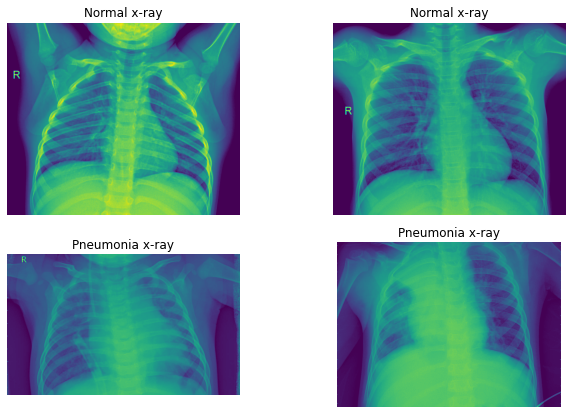

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

normal_images = os.listdir(train_normal_dir) # remember we declared these variables earlier
pneumonia_images = os.listdir(train_pneumonia_dir)

n_rows = 2 # one row for normal and other for pneumonia
n_columns = 2 # we're plotting two images of each

# picking random images from the folders
normal_img_1 = os.path.join(train_normal_dir, random.choice(normal_images))
normal_img_2 = os.path.join(train_normal_dir, random.choice(normal_images))
pneumonia_img_1 = os.path.join(train_pneumonia_dir, random.choice(pneumonia_images))
pneumonia_img_2 = os.path.join(train_pneumonia_dir, random.choice(pneumonia_images))

# putting the random images in a list to make it less verbose to use when plotting
img_list =  [
            mpimg.imread(normal_img_1), 
            mpimg.imread(normal_img_2),
            mpimg.imread(pneumonia_img_1), 
            mpimg.imread(pneumonia_img_2)
            ]

# configuring images size and spacing
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top = 0.90, bottom=0.10, hspace=1.5, wspace=0.4)

# displaying the images
plot = fig.add_subplot(1, 2, 1)
plt.imshow(img_list[0])
plot.axis('Off')
plot.set_title('Normal x-ray')

plot = fig.add_subplot(1, 2, 2)
plt.imshow(img_list[1])
plot.axis('Off')
plot.set_title('Normal x-ray')

plot = fig.add_subplot(2, 2, 3)
plt.imshow(img_list[2])
plot.axis('Off')
plot.set_title('Pneumonia x-ray')

plot = fig.add_subplot(2, 2, 4)
plt.imshow(img_list[3])
plot.axis('Off')
plot.set_title('Pneumonia x-ray')

plt.show()


I ran the previous code cell a few times. If you haven't done this already, I strongly recommend you to do so. Try running it multiple times, always looking at the displayed images and try to think what you can tell about the data we have. 

After running the previous code cell a few times, I can already say some things about the dataset. Things I noticed:
- The images have different sizes
- Some images are coloured while some are in grayscale
- Some images show just the chest, while others show other parts of the body (like shoulders, arms, chins, necks)
- The bodies are in different positions/angles

These are some observations I made. Maybe by inspecting even further I could think of even more things about the data. But we'll move on. 

Personally, I can't tell the difference between a Normal and a Pneumonia x-ray. And in my opinion it makes it even more interesting. Since I can't consistently classify the images, I hope my Neural Network can. 

### Defining and training our model

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

In [14]:
# feel free to experiment with different values later
n_batch = 32
n_epochs = 18 
lr_value = 1e-4

I add convolutional layers with pooling and flatten the final result to feed into the dense layers. Then I compile the model.

In [15]:
try:
  tf.keras.backend.clear_session()
except:
  pass

model = tf.keras.models.Sequential([
    # Since most images are coloured, we'll use 
    # 3 bytes for RGB
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
    # remember that the target_size used on the generator must have the same
    # value as the input shape used here
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    # Only 1 output neuron because it's a sigmoid activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=lr_value),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59168)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1893408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

I'll rescale our images to normalize. And using the ImageDataGenerator, we can automatically label our images according to the directories names. 

For the train generator I'll pass the training directory as a parameter and it will get the folders' names and use them to label our data. The 'test/NORMAL' folder has normal x-ray images and the 'test/PNEUMONIA' folder has pneumonia images, and the labels will be automatically assigned by the image generator. 

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = n_batch,
                                                    class_mode = 'binary',
                                                    target_size = (180, 180)) 

val_datagen = ImageDataGenerator(rescale = 1.0/255.) 
val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size = n_batch,
                                                 class_mode = 'binary',
                                                 target_size = (180, 180))

test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size = n_batch,
                                                  class_mode = 'binary',
                                                  target_size = (180, 180))

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


We can finally fit the model. I'm saving our fit history to a variable called 'history' so I can plot some useful informations later on. It might take a while.

In [17]:
history = model.fit(train_generator,
                    epochs = n_epochs, 
                    verbose = 1,
                    validation_data = val_generator)

Epoch 1/18
148/148 [==============================] - 50s 339ms/step - loss: 0.4014 - accuracy: 0.7970 - val_loss: 0.2763 - val_accuracy: 0.8870
Epoch 2/18
148/148 [==============================] - 50s 335ms/step - loss: 0.2753 - accuracy: 0.9053 - val_loss: 0.2432 - val_accuracy: 0.9176
Epoch 3/18
148/148 [==============================] - 50s 339ms/step - loss: 0.2425 - accuracy: 0.9384 - val_loss: 0.2317 - val_accuracy: 0.9655
Epoch 4/18
148/148 [==============================] - 51s 345ms/step - loss: 0.2302 - accuracy: 0.9518 - val_loss: 0.2268 - val_accuracy: 0.9330
Epoch 5/18
148/148 [==============================] - 51s 344ms/step - loss: 0.2225 - accuracy: 0.9541 - val_loss: 0.2176 - val_accuracy: 0.9655
Epoch 6/18
148/148 [==============================] - 51s 345ms/step - loss: 0.2163 - accuracy: 0.9614 - val_loss: 0.2076 - val_accuracy: 0.9713
Epoch 7/18
148/148 [==============================] - 51s 348ms/step - loss: 0.2135 - accuracy: 0.9597 - val_loss: 0.2091 - val_ac

So, our training accuracy steadily increases throughout the epochs (even though sometimes it goes down a little), which is good. But our validation accuracy seems to bounce a little. But this is common, specially because our validation set isn't large.  

Now we're plotting accuracy and loss for both training and validation to visualize them and get some insights from it. 

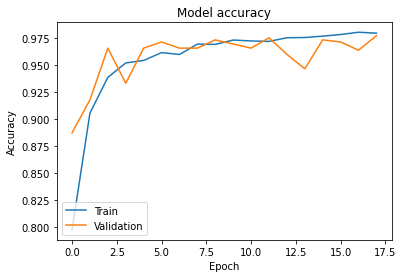

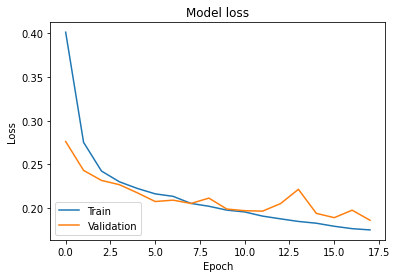

In [18]:
%matplotlib inline

# Just assigning some variables to make code cleaner
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

# Accuracy plot
plt.plot(acc_1)
plt.plot(val_acc_1)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()
# Loss plot
plt.plot(loss_1)
plt.plot(val_loss_1)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

The training dataset accuracy has an interesting and smooth growth and its loss is also a smooth decay. Our validation, even though it shows some rough edges, also looks decent. However, it's interesting to note that even if our results look good (high accuracy and low loss), the validation results are worse than our training results through most of the training process. Or, in other words: our models is performing better with the training set than with the validation set. This **may be** a sign of overfitting. 

Later on, when I test our model with our test set, we'll have a better grasp of how well our model really performs. 

Now let's try with data augmentation. Then we can compare results. 


### Trying with data augmentation

From [Tensorflow documentation](https://www.tensorflow.org/tutorials/images/data_augmentation): Data augmentation is "a technique to increase the diversity of your training set by applying random (but realistic) transformations". 

In other words: we're artificially generating new data by applying some random transformations to the data we already have. Some examples of such transformations are cropping, zooming and rotating. 

It makes sense in this dataset because, as we saw earlier, the dataset has x-ray images in different positions, with different sizes and etc. 

By doing this, we can have a larger training set even though we didn't add any actual images to our set. This is useful to prevent/reduce overfitting, by making our training set more diverse (even if artificially). 

I'm doing this using the image generator. Remember that we only apply data augmentation to our training set, and not to our validation and test sets. 

In [19]:
# Data augmentation to our training set
train_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=30, 
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = n_batch,
                                                    class_mode = 'binary',
                                                    target_size = (180, 180))

Found 4710 images belonging to 2 classes.


Now, I'll create a new model so later on we can compare both models. 

In [20]:
model_2 = tf.keras.models.Sequential([
    # Since most images are coloured, we'll use 
    # 3 bytes for RGB
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
    # remember that the target_size used on the generator must have the same
    # value as the input shape used here
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'), 
    # Only 1 output neuron because it's a sigmoid activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=lr_value),
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 59168)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1893408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
history = model_2.fit(train_generator,
                    epochs = n_epochs,
                    verbose = 1,
                    validation_data = val_generator)

Epoch 1/18
148/148 [==============================] - 81s 549ms/step - loss: 0.5433 - accuracy: 0.7503 - val_loss: 0.4497 - val_accuracy: 0.7529
Epoch 2/18
148/148 [==============================] - 81s 551ms/step - loss: 0.4413 - accuracy: 0.7898 - val_loss: 0.3391 - val_accuracy: 0.8678
Epoch 3/18
148/148 [==============================] - 81s 547ms/step - loss: 0.3835 - accuracy: 0.8204 - val_loss: 0.2320 - val_accuracy: 0.9119
Epoch 4/18
148/148 [==============================] - 81s 550ms/step - loss: 0.3702 - accuracy: 0.8285 - val_loss: 0.4745 - val_accuracy: 0.7816
Epoch 5/18
148/148 [==============================] - 81s 548ms/step - loss: 0.3440 - accuracy: 0.8439 - val_loss: 0.1898 - val_accuracy: 0.9387
Epoch 6/18
148/148 [==============================] - 81s 550ms/step - loss: 0.3328 - accuracy: 0.8469 - val_loss: 0.3210 - val_accuracy: 0.8563
Epoch 7/18
148/148 [==============================] - 81s 548ms/step - loss: 0.3280 - accuracy: 0.8505 - val_loss: 0.1952 - val_ac

You may have noticed that our training took longer this time. That's because we have more data to train on, even though it's artificially generated data. Be mindful of that. Data augmentation can **possibly** cause a huge increase in training time, while not improving accuracy as much, if overdone. 

You may also have noticed that our training set accuracy actually got lower. Again, this is because our data is far more diverse now.

Now, plotting accuracies and losses again.

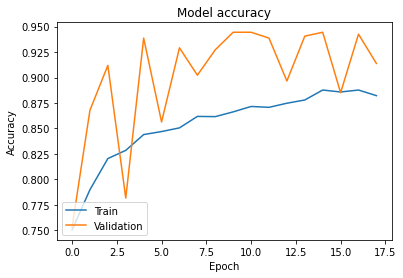

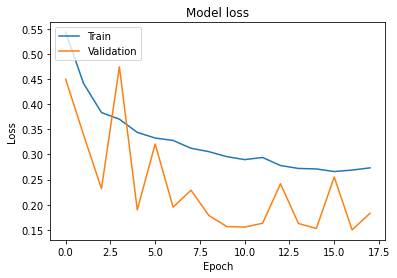

In [22]:
%matplotlib inline

# Just assigning some variables to make code cleaner
acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

# Accuracy plot
plt.plot(acc_2)
plt.plot(val_acc_2)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()
# Loss plot
plt.plot(loss_2)
plt.plot(val_loss_2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

So we can see our accuracy in the training set got significantly lower compared to our first model. But one interesting to notice is that, this time, our validation set had a better performance at most stages of the training process. In other words, our model now is better at classifying previously unseen images than classifying its own training set. It might mean that, this time, our model isn't suffering from overfitting. 

Our validation lines still present some rough edges, with significant dips and spikes. But again, this might be because our validation set isn't large at all, even after we enlarged it.

But now let's compare both models with our test set. 

### Comparing both models

Interestingly enough our model without data augmentation had better results in the validation set (AND in the training set). 

But let's see how they compare with our test data. The test set is usually a separate dataset to evaluate how well would our model do with real world images. So it's a good idea to keep it locked until the latest stages of the model development.  

In [23]:
print("Evaluation without data augmentation:")
result_1 = model.evaluate(test_generator)
print("Model loss: {:.5f}".format(result_1[0]))
print("Model accuracy: {:.5f}".format(result_1[1]))
print("Accuracy in %: {:.3f}%".format(result_1[1]*100))

Evaluation without data augmentation:
20/20 [==============================] - 5s 258ms/step - loss: 1.1281 - accuracy: 0.7740
Model loss: 1.12805
Model accuracy: 0.77404
Accuracy in %: 77.404%


In [24]:
print("Evaluation with data augmentation:")
result_2 = model_2.evaluate(test_generator)
print("Model loss: {:.5f}".format(result_2[0]))
print("Model accuracy: {:.5f}".format(result_2[1]))
print("Accuracy in %: {:.3f}%".format(result_2[1]*100))

Evaluation with data augmentation:
20/20 [==============================] - 5s 265ms/step - loss: 0.3203 - accuracy: 0.8670
Model loss: 0.32029
Model accuracy: 0.86699
Accuracy in %: 86.699%


Our accuracy with the test set improved by about 10 percentage points in our model with data augmentation compared to the model without data augmentation. It's a great improvement! 

Let's go further in our analysis with the help of some plots. In the following plot I use Plotly. 

In [25]:
import plotly.offline as py
import plotly.graph_objs as go

train_accuracy_1 = go.Scatter(
    y = acc_1,
    mode = 'lines',
    name = 'Training accuracy without DA'
    )
val_accuracy_1 = go.Scatter(
    y = val_acc_1,
    mode = 'lines',
    name = 'Validation accuracy without DA'
    )
train_accuracy_2 = go.Scatter(
    y = acc_2,
    mode = 'lines',
    name = 'Training accuracy with DA'
    )
val_accuracy_2 = go.Scatter(
    y = val_acc_2,
    mode = 'lines',
    name = 'Validation accuracy with DA'
)

data = [train_accuracy_1, 
        val_accuracy_1,
        train_accuracy_2,
        val_accuracy_2]


You can hover your mouse over the lines to see more detailed information. You can also choose to hide some lines by clicking them in the legends to the right. 

If you're seeing this on Github, please note that interactive plots currently do not work on github pages. For a better visualization, see it on [Colab](https://colab.research.google.com/drive/1J3wTArG8H1dClS7VsgbUCzmboD_BaUdZ?usp=sharing).

In [26]:
py.iplot(data)

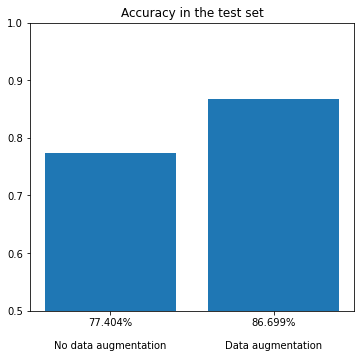

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.70,1])
ax.set_ylim([0.5,1]) # note the plot is truncated 
plt.title('Accuracy in the test set')
ax.bar(['{:.3f}%\n\nNo data augmentation'.format(result_1[1]*100), 
        '{:.3f}%\n\nData augmentation'.format(result_2[1]*100)], [result_1[1], result_2[1]])
plt.show()

From our line charts we could think that our first model was better in every aspect, since it got better results with the training and the validation sets, compared to our second model. But even though our model trained without data augmentation seemed better during the training phase, the evaluation with the test set shows that data augmentation makes a big difference with previously unseen data. 

By using data augmentation I managed to improve our accuracy in about 10 percentage points, which is great! Data augmentation is a powerful technique that should at least be considered whenever possible. 

